# Algoritmo de red convolucional para la clasificación detección temprana de supernovas

In [30]:
import numpy as np
import pickle as pkl
import os
import sys
import time
import torch
from torch import nn
import torchvision
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Red convolucional

### Se abre la data pre-procesada

In [31]:
# Función para cargar el contenido del archivo .pkl
def load_pickle_data(filename):
    with open(filename, 'rb') as f:
        data = pkl.load(f)
    return data

# Cargar el archivo
filename = 'processed_data.pkl' 
data_procesada = load_pickle_data(filename)

# Visualizar el contenido
print('keys de pkl', data_procesada.keys())
print('keys de Test',data_procesada['Validation'].keys())
data_procesada['Validation']['labels']

keys de pkl dict_keys(['Train', 'Validation', 'Test'])
keys de Test dict_keys(['images', 'labels', 'features'])


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,

In [32]:
def preparar_imagenes_para_modelo(data_dict, key_principal='Train', key_imagenes='images'):
    # Extraer imágenes del diccionario
    imagenes = data_dict[key_principal][key_imagenes]
    
    # Cambiar el orden de las dimensiones a [canales, altura, ancho]
    imagenes = np.transpose(imagenes, (0, 3, 1, 2))
    
    # Convertir a tensor de PyTorch
    imagenes_tensor = torch.tensor(imagenes, dtype=torch.float32)

    
    return imagenes_tensor

# Preparar las imágenes para el modelo
Train = preparar_imagenes_para_modelo(data_procesada)
Val = preparar_imagenes_para_modelo(data_procesada, key_principal='Validation')
Test = preparar_imagenes_para_modelo(data_procesada, key_principal='Test')

print('tipo de dato de Train:', Train.type)
print('forma de Train:', Train.shape)
print('forma de Validation:', Val.shape)
print('forma de Test:', Test.shape)



tipo de dato de Train: <built-in method type of Tensor object at 0x0000011EDEED8EF0>
forma de Train: torch.Size([72710, 3, 21, 21])
forma de Validation: torch.Size([500, 3, 21, 21])
forma de Test: torch.Size([500, 3, 21, 21])


In [33]:
def extraer_etiquetas(data_dict, key_principal='Train', key_etiquetas='labels'):
    # Extraer etiquetas del diccionario
    etiquetas = data_dict[key_principal][key_etiquetas]
    # Convertir a tensor de PyTorch
    etiquetas_tensor = torch.tensor(etiquetas, dtype=torch.long)  # Usamos dtype long porque son índices de clase
    return etiquetas_tensor


### Extracción de metadata:

In [34]:
def extraer_metadata(data_dict, key_principal='Train', key_metadata='features'):
    # Extraer características de metadatos del diccionario
    metadata = data_dict[key_principal][key_metadata]
    
    # Convertir explícitamente a float32
    metadata = metadata.astype(np.float32)
    
    # Convertir a tensor de PyTorch
    metadata_tensor = torch.tensor(metadata, dtype=torch.float32)
    
    return metadata_tensor


# Extraer características de metadatos para los conjuntos de datos
metadata_train = extraer_metadata(data_procesada)
metadata_val = extraer_metadata(data_procesada, key_principal='Validation')
metadata_test = extraer_metadata(data_procesada, key_principal='Test')

print('forma de metadata_train:', metadata_train.shape)
print('forma de metadata_val:', metadata_val.shape)
print('forma de metadata_test:', metadata_test.shape)

metadata_val[0]


forma de metadata_train: torch.Size([72710, 26])
forma de metadata_val: torch.Size([500, 26])
forma de metadata_test: torch.Size([500, 26])


tensor([ 0.7788, -0.6295,  0.0887,  0.4651,  1.1523,  0.0935,  2.1225, -0.8817,
         1.1350,  1.1945,  0.2198,  0.3951,  1.1309,  0.9652, -0.6643, -0.0798,
        -2.0312, -0.2051, -0.1635,  0.5879,  0.2048,  1.6357, -0.8917, -0.1424,
        -0.2300, -0.1352])

## Modelo convolucional, incorporando invariancia rotacional

In [35]:
class CNNModel(nn.Module):
    def __init__(self, dropout_p, num_classes=5):
        super().__init__()
        # Zero padding para evitar perder datos de las imágenes después de las convoluciones
        self.padding = nn.ZeroPad2d(3)

        # Bloques de convolución
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # MLP
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2304, 64),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def rotate_input(self, x):
        # Rotaciones para la invariancia 
        x_90 = torch.rot90(x, 1, [2, 3])
        x_180 = torch.rot90(x, 2, [2, 3])
        x_270 = torch.rot90(x, 3, [2, 3])
        return torch.cat([x, x_90, x_180, x_270], dim=0)

    def cyclic_pooling(self, x):
        # Suponemos que el tamaño del batch original es B
        B = x.size(0) // 4
        return (x[:B] + x[B:2*B] + x[2*B:3*B] + x[3*B:]) / 4.0

    def forward(self, x):
        # Zero padding
        x = self.padding(x)
        
        # Rotación de la entrada
        x_rotated = self.rotate_input(x)
        
        # Pasar por bloques convolucionales
        x_rotated = self.conv_blocks(x_rotated)
        
        # Pooling Cíclico
        x_pooled = self.cyclic_pooling(x_rotated)
        
        # Pasar por MLP
        out = self.mlp(x_pooled)
        
        return out


## Función de entrenamiento y visualización

In [18]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.show()

In [36]:
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    # Predicción
    y_predicted = model(x_batch)

    # Cálculo de loss
    loss = criterion(y_predicted, y_batch)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss


def evaluate(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0

    for x_val, y_val in val_loader:
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)
        
        loss = criterion(y_predicted, y_val)

        class_prediction = torch.argmax(y_predicted, axis=1).long()

        cumulative_predictions += (y_val == class_prediction).sum().item()
        cumulative_loss += loss.item()
        data_count += y_val.shape[0]

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / len(val_loader)

    return val_acc, val_loss



def train_model(
    model,
    train_data_images,
    train_data_labels,
    val_data_images,
    val_data_labels,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu,
    patience=5
):

    if use_gpu:
        model.cuda()

    # Definición de dataloader
    train_dataset = torch.utils.data.TensorDataset(train_data_images, train_data_labels)
    val_dataset = torch.utils.data.TensorDataset(val_data_images, val_data_labels)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_data_images), shuffle=False, pin_memory=use_gpu)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        # Entrenamiento del modelo
        model.train()

        for i, data in enumerate(train_loader):
            (x_batch, y_batch) = data  
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.shape[0]

            # Calculamos número de aciertos
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            if (i + 1) % 117 == 0:
                print(f"Iteration {i + 1} - Batch {i + 1}/{len(train_loader)} - Train loss: {cumulative_train_loss / train_loss_count}, Train acc: {cumulative_train_corrects / train_acc_count}")

        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}")

        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

        # Lógica de early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement == patience:
            print(f"Early stopping at epoch {epoch + 1} due to no improvement after {patience} epochs.")
            break

    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")
    model.cpu()

    return curves


## Instanciamos el modelo

Epoch 1/50
Iteration 117 - Batch 117/2273 - Train loss: 1.6108886777845204, Train acc: 0.1920405982905983
Iteration 234 - Batch 234/2273 - Train loss: 1.5990856126842337, Train acc: 0.2325053418803419
Iteration 351 - Batch 351/2273 - Train loss: 1.5769102960570245, Train acc: 0.265224358974359
Iteration 468 - Batch 468/2273 - Train loss: 1.5560094049343696, Train acc: 0.2905315170940171
Iteration 585 - Batch 585/2273 - Train loss: 1.5294325078654494, Train acc: 0.31522435897435896
Iteration 702 - Batch 702/2273 - Train loss: 1.506116941613689, Train acc: 0.3369391025641026
Iteration 819 - Batch 819/2273 - Train loss: 1.4780878326395055, Train acc: 0.36061507936507936
Iteration 936 - Batch 936/2273 - Train loss: 1.4503967036676204, Train acc: 0.3802083333333333
Iteration 1053 - Batch 1053/2273 - Train loss: 1.4285623169126447, Train acc: 0.3958036562203229
Iteration 1170 - Batch 1170/2273 - Train loss: 1.4054714099973695, Train acc: 0.4099893162393162
Iteration 1287 - Batch 1287/2273 - 

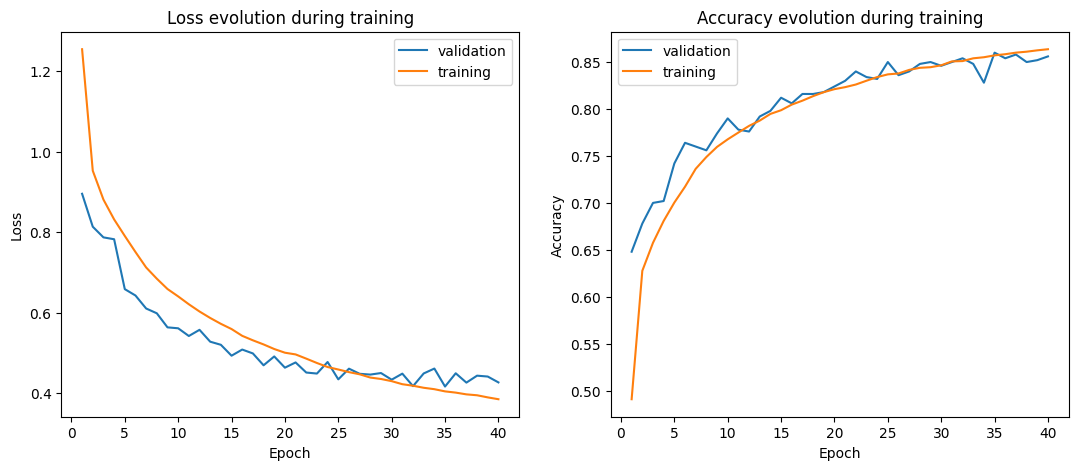

In [37]:
# Instanciación del modelo
lr = 5e-5
dropout_p = 0.6
batch_size = 32
criterion = nn.CrossEntropyLoss()
epochs = 50
model = CNNModel(dropout_p=dropout_p)

# Dividir las imágenes y metadatos en conjuntos de entrenamiento y validación
Train_images = preparar_imagenes_para_modelo(data_procesada)
Val_images = preparar_imagenes_para_modelo(data_procesada, key_principal='Validation')
Train_labels = extraer_etiquetas(data_procesada)
Val_labels = extraer_etiquetas(data_procesada, key_principal='Validation')

curves = train_model(
    model,
    Train_images,  
    Train_labels,
    Val_images,    
    Val_labels,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
)

# Mostrar las curvas de entrenamiento
show_curves(curves)



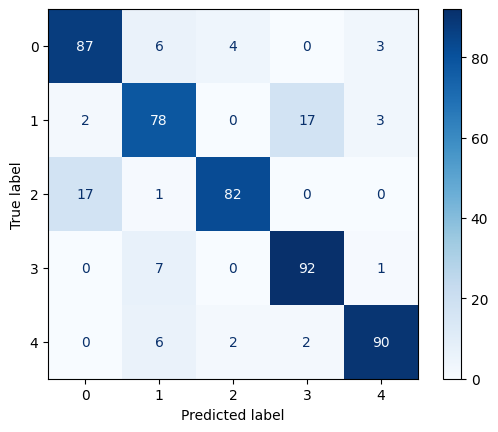

In [38]:
def predict(model, data_loader, use_gpu):
    all_preds = []
    all_true = []
    
    if use_gpu:
        model = model.cuda()  # Transfiere el modelo a la GPU
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in data_loader:
            if use_gpu:
                inputs = inputs.cuda()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_true.extend(labels.numpy())

    return all_true, all_preds

Test_images = preparar_imagenes_para_modelo(data_procesada, key_principal='Test')
Test_labels = extraer_etiquetas(data_procesada, key_principal='Test')
# Definición de dataloader
test_dataset = torch.utils.data.TensorDataset(Test_images, Test_labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

true_labels, predicted_labels = predict(model, test_loader, use_gpu=True)
cm = confusion_matrix(true_labels, predicted_labels)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4]) # Asume que tienes 5 clases, cámbialo según tu número de clases
disp.plot(cmap=plt.cm.Blues)
